In [141]:
# Settings
#filename    = '/home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5'
#filename     = '/home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2015_10_28/background_trigger_logic_600th_151028.hdf5'
#filename    = '/home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2015_10_02/Kr_Measurement_1000TH_1_151002.hdf5'
filename    = '/home/a_fieg02/Desktop/krypton_sample.hdf5'
file_format = 'hdf5'
#loglevel    = 'DEBUG'

In [142]:
import logging
log = logging.getLogger('Gaseous basic statistics')
log.setLevel('DEBUG')

import numpy as np

import matplotlib   # Needed for font size spec, color map transformation function bla bla
%matplotlib inline
matplotlib.rc('font', size=16)
import matplotlib.pyplot as plt

# Optional progress bar
try:
    from tqdm import tqdm
except ImportError:
    log.debug("You don't have tqdm, I can't give you a nice progress bar...")
    def dummy(*args,**kwargs):
        return args[0]
    tqdm = dummy

from recarray_tools import append_fields, fields_view, group_by, filter_on_fields, fields_data



In [143]:
##
# Load the data
##

log.debug("Now loading %s (file format=%s)..." % (filename, file_format))

# Slurp peaks and events into memory
# WARNING: For a large dataset, use pax to remove big low-level fields first
# (area_per_channel, does_channel_contribute, does_channel_have_noise)
try:
    # Load the file using pax 3's IO code
    from pax.formats import flat_data_formats
    ioformat = flat_data_formats[file_format]()
    ioformat.open(filename, 'r')
    events = ioformat.read_data('Event')
    try:
        peaks = ioformat.read_data('Peak')
    except KeyError:
        peaks = None
        log.info("There is no peak table")
    hits = ioformat.read_data('Hit')
    ioformat.close()
except ImportError:
    log.debug("You don't have pax 3 installed, falling back to HDF5-specific code...")
    import h5py
    f = h5py.File(filename)
    events = f.get('Event')[:]
    peaks = f.get('Peak')[:]
    hits = f.get('Hit')[:]
    f.close()
if peaks != None:
    log.info("Loaded %s, containing %d peaks (%0.2f MB RAM) and %d events (%0.2f MB RAM)" % (
    filename, len(peaks), peaks.nbytes/10**6, len(events), events.nbytes/10**6))
if len(events) == 0:
    raise ValueError("You don't have any events in this dataset!")

DEBUG:Gaseous basic statistics:Now loading /home/a_fieg02/Desktop/krypton_sample.hdf5 (file format=hdf5)...
/home/a_fieg02/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
INFO:Gaseous basic statistics:Loaded /home/a_fieg02/Desktop/krypton_sample.hdf5, containing 57930 peaks (144.82 MB RAM) and 9432 events (3.62 MB RAM)


In [144]:
from recarray_tools import append_fields, fields_view, group_by, filter_on_fields, fields_data

# Get rid of pathological events without peaks immediately, later code doesn't work on these ...
n_before = len(events)

events = filter_on_fields(events, peaks, 'Event')

log.debug("Deleted %d events without any peaks (%0.4f%% of total)" % (
    n_before-len(events), 100*(n_before-len(events))/n_before))

print("Deleted %d events without any peaks (%0.4f%% of total)" % (
    n_before-len(events), 100*(n_before-len(events))/n_before))


events.dtype.names

peaks.dtype.names


##
# Add extra peak fields here
##



# Get the positions of these s2's

# Add and x and y field to each s2 peak, using the specified algorithm i.e. Neural Net

print('done')
print("number of events selected before:", len(events))

##
# Add n_S1, n_S2, ... in each event
##

# Group peaks by event
peaks_per_event = group_by(peaks, 'Event')
assert len(peaks_per_event) == len(events)

peak_types = [b's1', b's2', b'unknown', b'noise', b'lone_hit']
# Add number of individual peak types
for pt in peak_types:
    events = append_fields(events,
                           'n_'+pt.decode(),
                           np.array([len(x[x['type'] == pt]) for x in peaks_per_event]))
    
print('done')
print("Tell me the peaktypes S2:", len(peaks[(peaks['type'] == b's2')])) 
print("Tell me the peaktypes S1:", len(peaks[(peaks['type'] == b's1')])) 
print("Tell me the peaktypes noise:", len(peaks[(peaks['type'] == b'noise')])) 
print("Tell me the peaktypes unknown:", len(peaks[(peaks['type'] == b'unknown')]))
print("Tell me the peaktypes lone_hit:", len(peaks[(peaks['type'] == b'lone_hit')]))  

events.dtype.names



DEBUG:Gaseous basic statistics:Deleted 0 events without any peaks (0.0000% of total)


Deleted 0 events without any peaks (0.0000% of total)
done
number of events selected before: 9432
done
Tell me the peaktypes S2: 6
Tell me the peaktypes S1: 16838
Tell me the peaktypes noise: 0
Tell me the peaktypes unknown: 30
Tell me the peaktypes lone_hit: 41056


('Event',
 'n_interactions',
 'interactions_start',
 'n_peaks',
 'peaks_start',
 'dataset_name',
 'event_number',
 'is_channel_suspicious',
 'n_channels',
 'n_hits_rejected',
 'noise_pulses_in',
 'sample_duration',
 'start_time',
 'stop_time',
 'n_s1',
 'n_s2',
 'n_unknown',
 'n_noise',
 'n_lone_hit')

In [145]:
n_before = len(events)
cut = (events['n_s1'] >= 2)
events = events[cut]
peaks_per_event = [x for i, x in enumerate(peaks_per_event) if cut[i]]

log.debug("%0.2f%% of events have >=2 S1, keeping only those." % (100*len(events)/n_before))
print('done!')
print("number of events selected:", len(events))

DEBUG:Gaseous basic statistics:49.71% of events have >=2 S1, keeping only those.


done!
number of events selected: 4689


In [146]:
ignore_fields = ['Event', 'Peak','type',
                 # recfunctions have trouble with subarrays...
                 'hits_per_channel','area_per_channel','hits_start','n_reconstructed_positions','reconstructed_positions_start','','area_midpoint','area_fraction_top','hits_per_channel','n_saturated_per_channel','range_area_decile','is_channel_suspicious','n_hits_rejected','noise_pulses_in','sum_waveform','sum_waveform_top']
for pt in (b's1',):
    main_peaks = []
    secondary_peaks =[]
    for pks in tqdm(peaks_per_event, desc='Selecting %ss' % pt.decode()):
        peaks_of_this_type =  pks[pks['type'] == pt]
        main_peaks.append(peaks_of_this_type[np.argmax(peaks_of_this_type['area'])])
        peaks_of_this_type=peaks_of_this_type[peaks_of_this_type["area"]<peaks_of_this_type["area"].max()]
        secondary_peaks.append(peaks_of_this_type[np.argmax(peaks_of_this_type['area'])])     


    main_peaks = np.array(main_peaks)
    assert len(main_peaks) == len(peaks_per_event)
    secondary_peaks = np.array(secondary_peaks)
    assert len(secondary_peaks) == len(peaks_per_event)   

    
      
    for fn in main_peaks.dtype.names:
        if fn in ignore_fields:
            continue
        events = append_fields(events,
                               "%s_%s" % (pt.decode(), fn),
                               main_peaks[fn])


    for fn in secondary_peaks.dtype.names:
        if fn in ignore_fields:
            continue
        events = append_fields(events,
                               "%s_1_%s" % (pt.decode(), fn),
                               secondary_peaks[fn])
    
    
    print('done')




done


In [147]:
events = append_fields(events, 'sep_time', events['s1_1_hit_time_mean'] - events['s1_hit_time_mean'])


# Main selection of populations
print("total number of events:", len(events))

selected_events = events[

    (events['s1_hit_time_mean'] < events['s1_1_hit_time_mean'])  
]

print("number of events selected:", len(selected_events))



total number of events: 4689
number of events selected: 4555


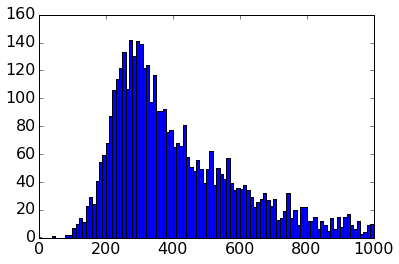

In [152]:
labels = {}
labels['s1_area'] = "S1 Area [pe]"
labels['s1_1_area'] = "S1_1 Area [pe]"

def plot_density(selected, xvar, yvar, xmin, xmax, ymin, ymax, log=False):
    
    for key in (xvar, yvar):
        try:
            labels[key]
        except KeyError:
            labels[key] = key

    xbins = np.linspace(xmin, xmax, 100)
    ybins = np.linspace(ymin, ymax, 100)

    counts, _, _ = np.histogram2d(selected[xvar], selected[yvar], bins=(xbins, ybins))
    counts = counts.T

    fig, ax = plt.subplots(figsize=(12, 7))
    
    norm=None
    if log:
        norm=LogNorm()
    
    a = ax.pcolormesh(xbins, ybins, counts, norm=norm)

    cbar = plt.colorbar(a)
    cbar.ax.get_yaxis().labelpad = 25
    cbar.set_label('counts', rotation=270)
    plt.title(filename)
    plt.xlabel(labels[xvar])
    plt.ylabel(labels[yvar])

    plt.show()
    return

#plot_density(selected_events, "s1_area","s1_1_area",0,200,0,50)        

plt.hist(events["sep_time"],bins=100,range=(0,1000))
plt.show()
